# Week 9 Assignment: NLP Text classification

Create a NLP text classifier to predict whether a text message is spam. 

1) Load the dataset which includes 2 fields: (text and label) where label  indicates whether the message is “spam” or "not spam"  (eg: ham).

2) Perform basic EDA

3) Perform preprocessing of text (eg: lower-case, tokenization, removal of stop words, stemming/lemmatization, etc. as needed)

4) Vectorize Text (eg: BoW, TF-IDF, etc)

5) Create a model, using at least 2 different ML algorithms
    
 * Split the data into training and testing set
 * Train the model on training, then predict and assess performance on test
 * Predict custom messages (eg: your own custom message, at least 3) to evaluate how well your model categorized it

In [1]:
import numpy as np
import pandas as pd
import string
import re
import itertools

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.chunk import tree2conlltags
from nltk.chunk import conllstr2tree

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.utils import resample



import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("spam.csv")

In [3]:
df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
# Make a copy without any transformations
df_clean = df.copy()

In [5]:
df.loc[2].text

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [6]:
df['length'] = df.apply(lambda row: len(row.text), axis = 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
 2   length  5572 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 130.7+ KB


In [8]:
df.describe()

,length
count,5572.000000
mean,80.118808
std,59.690841
min,2.000000
25%,36.000000
50%,61.000000
75%,121.000000
max,910.000000


<AxesSubplot:xlabel='label', ylabel='count'>

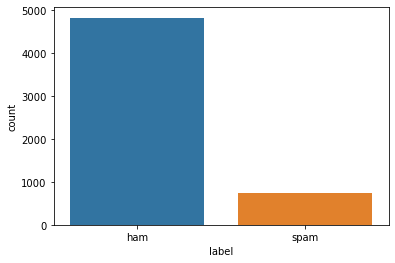

In [9]:
sns.countplot(x=df['label'])

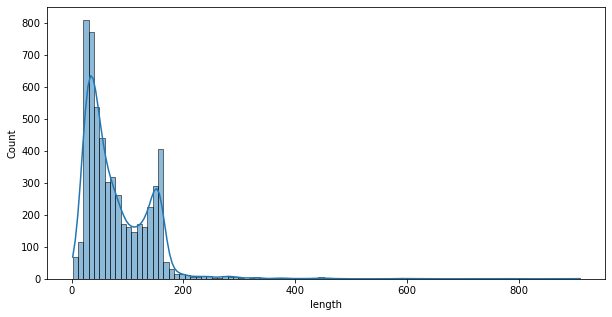

In [10]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='length', kde=True);

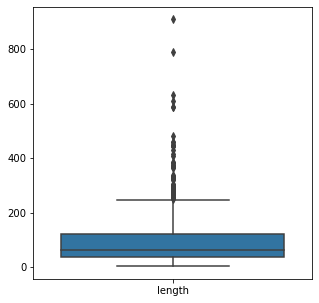

In [11]:
plt.figure(figsize=(5, 5))
sns.boxplot(data=df);

## Perform Data Cleaning

In [12]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, 
    remove numbers.'''
    text = text.lower()
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [13]:
# Let's take a look at the updated text
df['text'] = pd.DataFrame(df.text.apply(round1))
df

,label,text,length
0,ham,"go until jurong point, crazy.. available only ...",111
1,ham,ok lar... joking wif u oni...,29
2,spam,free entry in a wkly comp to win fa cup final...,155
3,ham,u dun say so early hor... u c already then say...,49
4,ham,"nah i don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,spam,this is the time we have tried contact u. u ...,161
5568,ham,will ì_ b going to esplanade fr home?,37
5569,ham,"pity, * was in mood for that. so...any other s...",57
5570,ham,the guy did some bitching but i acted like i'd...,125


In [14]:
useless_words = stopwords.words("english") + list(string.punctuation)

In [15]:
df['text'] = [word for word in df['text'] if not word in useless_words]

In [16]:
df

,label,text,length
0,ham,"go until jurong point, crazy.. available only ...",111
1,ham,ok lar... joking wif u oni...,29
2,spam,free entry in a wkly comp to win fa cup final...,155
3,ham,u dun say so early hor... u c already then say...,49
4,ham,"nah i don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,spam,this is the time we have tried contact u. u ...,161
5568,ham,will ì_ b going to esplanade fr home?,37
5569,ham,"pity, * was in mood for that. so...any other s...",57
5570,ham,the guy did some bitching but i acted like i'd...,125


In [17]:
df['tokenized_text'] = df.apply(lambda row: word_tokenize(row['text']), axis=1)

In [18]:
df['tok_length'] = df.apply(lambda row: len(row.tokenized_text), axis = 1)

In [19]:
df

,label,text,length,tokenized_text,tok_length
0,ham,"go until jurong point, crazy.. available only ...",111,"[go, until, jurong, point, ,, crazy, .., avail...",24
1,ham,ok lar... joking wif u oni...,29,"[ok, lar, ..., joking, wif, u, oni, ...]",8
2,spam,free entry in a wkly comp to win fa cup final...,155,"[free, entry, in, a, wkly, comp, to, win, fa, ...",32
3,ham,u dun say so early hor... u c already then say...,49,"[u, dun, say, so, early, hor, ..., u, c, alrea...",13
4,ham,"nah i don't think he goes to usf, he lives aro...",61,"[nah, i, do, n't, think, he, goes, to, usf, ,,...",15
...,...,...,...,...,...
5567,spam,this is the time we have tried contact u. u ...,161,"[this, is, the, time, we, have, tried, contact...",29
5568,ham,will ì_ b going to esplanade fr home?,37,"[will, ì_, b, going, to, esplanade, fr, home, ?]",9
5569,ham,"pity, * was in mood for that. so...any other s...",57,"[pity, ,, *, was, in, mood, for, that, ., so, ...",15
5570,ham,the guy did some bitching but i acted like i'd...,125,"[the, guy, did, some, bitching, but, i, acted,...",27


In [20]:
df.tokenized_text

0       [go, until, jurong, point, ,, crazy, .., avail...
1                [ok, lar, ..., joking, wif, u, oni, ...]
2       [free, entry, in, a, wkly, comp, to, win, fa, ...
3       [u, dun, say, so, early, hor, ..., u, c, alrea...
4       [nah, i, do, n't, think, he, goes, to, usf, ,,...
                              ...                        
5567    [this, is, the, time, we, have, tried, contact...
5568     [will, ì_, b, going, to, esplanade, fr, home, ?]
5569    [pity, ,, *, was, in, mood, for, that, ., so, ...
5570    [the, guy, did, some, bitching, but, i, acted,...
5571                  [rofl, ., its, true, to, its, name]
Name: tokenized_text, Length: 5572, dtype: object

In [21]:
df2 = df.drop(columns=['text', 'length', 'tok_length'])
df2

,label,tokenized_text
0,ham,"[go, until, jurong, point, ,, crazy, .., avail..."
1,ham,"[ok, lar, ..., joking, wif, u, oni, ...]"
2,spam,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,ham,"[u, dun, say, so, early, hor, ..., u, c, alrea..."
4,ham,"[nah, i, do, n't, think, he, goes, to, usf, ,,..."
...,...,...
5567,spam,"[this, is, the, time, we, have, tried, contact..."
5568,ham,"[will, ì_, b, going, to, esplanade, fr, home, ?]"
5569,ham,"[pity, ,, *, was, in, mood, for, that, ., so, ..."
5570,ham,"[the, guy, did, some, bitching, but, i, acted,..."


In [22]:
# Change the column order
df2 = df2[['tokenized_text', 'label']]

In [23]:
df2

,tokenized_text,label
0,"[go, until, jurong, point, ,, crazy, .., avail...",ham
1,"[ok, lar, ..., joking, wif, u, oni, ...]",ham
2,"[free, entry, in, a, wkly, comp, to, win, fa, ...",spam
3,"[u, dun, say, so, early, hor, ..., u, c, alrea...",ham
4,"[nah, i, do, n't, think, he, goes, to, usf, ,,...",ham
...,...,...
5567,"[this, is, the, time, we, have, tried, contact...",spam
5568,"[will, ì_, b, going, to, esplanade, fr, home, ?]",ham
5569,"[pity, ,, *, was, in, mood, for, that, ., so, ...",ham
5570,"[the, guy, did, some, bitching, but, i, acted,...",ham


In [26]:
df_dict = df2.to_dict()

In [33]:
df_dict['label']

{0: 'ham',
 1: 'ham',
 2: 'spam',
 3: 'ham',
 4: 'ham',
 5: 'spam',
 6: 'ham',
 7: 'ham',
 8: 'spam',
 9: 'spam',
 10: 'ham',
 11: 'spam',
 12: 'spam',
 13: 'ham',
 14: 'ham',
 15: 'spam',
 16: 'ham',
 17: 'ham',
 18: 'ham',
 19: 'spam',
 20: 'ham',
 21: 'ham',
 22: 'ham',
 23: 'ham',
 24: 'ham',
 25: 'ham',
 26: 'ham',
 27: 'ham',
 28: 'ham',
 29: 'ham',
 30: 'ham',
 31: 'ham',
 32: 'ham',
 33: 'ham',
 34: 'spam',
 35: 'ham',
 36: 'ham',
 37: 'ham',
 38: 'ham',
 39: 'ham',
 40: 'ham',
 41: 'ham',
 42: 'spam',
 43: 'ham',
 44: 'ham',
 45: 'ham',
 46: 'ham',
 47: 'ham',
 48: 'ham',
 49: 'ham',
 50: 'ham',
 51: 'ham',
 52: 'ham',
 53: 'ham',
 54: 'spam',
 55: 'ham',
 56: 'spam',
 57: 'ham',
 58: 'ham',
 59: 'ham',
 60: 'ham',
 61: 'ham',
 62: 'ham',
 63: 'ham',
 64: 'ham',
 65: 'spam',
 66: 'ham',
 67: 'spam',
 68: 'spam',
 69: 'ham',
 70: 'ham',
 71: 'ham',
 72: 'ham',
 73: 'ham',
 74: 'ham',
 75: 'ham',
 76: 'ham',
 77: 'ham',
 78: 'ham',
 79: 'ham',
 80: 'ham',
 81: 'ham',
 82: 'ham',

## NLTK Version

## Scikit Learn Version

In [ ]:
df = df_clean.copy()

# Set `y` 
y = df.label 

# Drop the `label` column
df.drop("label", axis=1)

# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.33, random_state=53)

In [ ]:
print(y_train.shape)
print(X_train.shape)

### Models on Original Dataset

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(stop_words='english', strip_accents='unicode')

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

# Transform the test set 
count_test = count_vectorizer.transform(X_test)

In [ ]:
# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, strip_accents='unicode') 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [ ]:
# Get the feature names of `tfidf_vectorizer` 
print(tfidf_vectorizer.get_feature_names()[-10:])

# Get the feature names of `count_vectorizer` 
print(count_vectorizer.get_feature_names()[:10])

In [ ]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
count_df

In [ ]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_df

In [ ]:
clf = MultinomialNB() 

In [ ]:
clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)

print(metrics.classification_report(y_test, pred, digits=3))

print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['spam', 'ham'])
plot_confusion_matrix(cm, classes=['spam', 'ham'])

In [ ]:
clf = MultinomialNB() 

In [ ]:
clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)

print(metrics.classification_report(y_test, pred, digits=3))

print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['spam', 'ham'])
plot_confusion_matrix(cm, classes=['spam', 'ham'])

### Resample the Minority Class

In [ ]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

In [ ]:
# separate minority and majority classes
ham = X[X.label == 'ham']
spam = X[X.label == 'spam']

In [ ]:
# upsample minority
spam_upsampled = resample(spam,
                          replace=True, # sample with replacement
                          n_samples=len(ham), # match number in majority class
                          random_state=27) # reproducible results

In [ ]:
# combine majority and upsampled minority
upsampled = pd.concat([ham, spam_upsampled])

In [ ]:
# check new class counts
upsampled.label.value_counts()

### Post Resampling

In [ ]:
# balanced dataset
y_train = upsampled.label
X_train = upsampled.text

In [ ]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(stop_words='english', strip_accents='unicode')

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

# Transform the test set 
count_test = count_vectorizer.transform(X_test)

In [ ]:
X_test

In [ ]:
y_test

In [ ]:
# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', strip_accents='unicode') 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [ ]:
# Get the feature names of `tfidf_vectorizer` 
print(tfidf_vectorizer.get_feature_names()[-10:])

# Get the feature names of `count_vectorizer` 
print(count_vectorizer.get_feature_names()[:10])

In [ ]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
count_df

In [ ]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_df

In [ ]:
clf = MultinomialNB() 

In [ ]:
clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)

print(metrics.classification_report(y_test, pred, digits=3))

print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['spam', 'ham'])
plot_confusion_matrix(cm, classes=['spam', 'ham'])

In [ ]:
clf = MultinomialNB() 

In [ ]:
clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)

print(metrics.classification_report(y_test, pred, digits=3))

print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['spam', 'ham'])
plot_confusion_matrix(cm, classes=['spam', 'ham'])

In [ ]:
a = ["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

In [ ]:
a = ["We tried to call you re your reply to our sms for a free nokia mobile + free camcorder."]

In [ ]:
a = tfidf_vectorizer.transform(a)

In [ ]:
a.shape

In [ ]:
print(clf.predict(a))

### Example Spam

In [ ]:
list(df[df['label'] == 'spam'][1:5].text)

In [ ]:
list(df[df['label'] == 'ham'][1:5].text)